## Introduction

The purpose of this project is to identify a trend using time series datasets of climate data from seven major ocean basins and then project that trend into the future. In this project I will be looking at the the annual number of days the Artic ocean remains frozen.

In [186]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import welch
from sklearn.linear_model import LinearRegression

## Load Data

This data comes from the European Center for Medium-Range Weather Forecasting (ECMWF). This data is a small subsection from their most recent ERA5 report containing the sea surface temperature, wave height, and windspeed data for the Artic ocean (1940 - 2024).

For more details and to reference worldwide data for all seven oceans their website can be found here: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview

In [187]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/1zwbfmld6_kgSuA8ot0Apx-7KBtB5UMx2nGCcukeS21Y/export?format=csv')

## Data Exploration and Preparation

In [188]:
df.head()

sst        u10  hsig                 time  latitude  longitude
0  271.45996   0.009604   NaN  1940-01-01 12:00:00        70     -140.1
1  271.45996   6.529120   NaN  1940-01-02 12:00:00        70     -140.1
2  271.45996   5.675279   NaN  1940-01-03 12:00:00        70     -140.1
3  271.45996 -10.479511   NaN  1940-01-04 12:00:00        70     -140.1
4  271.45996 -14.644253   NaN  1940-01-05 12:00:00        70     -140.1

In [189]:
df.dtypes

sst          float64
u10          float64
hsig         float64
time          object
latitude       int64
longitude    float64
dtype: object

In [190]:
df['year'] = pd.DatetimeIndex(df['time']).year #formatting time

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30747 entries, 0 to 30746
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sst        30747 non-null  float64
 1   u10        30747 non-null  float64
 2   hsig       6123 non-null   float64
 3   time       30747 non-null  object 
 4   latitude   30747 non-null  int64  
 5   longitude  30747 non-null  float64
 6   year       30747 non-null  int32  
dtypes: float64(4), int32(1), int64(1), object(1)
memory usage: 1.5+ MB


Calculating the number of days the ocean is frozen each year

In [192]:
days_frozen = df.groupby('year')['hsig'].apply(lambda x: x.isna().sum())

Creating a new dataset for days_frozen

In [193]:
days_frozen_df = days_frozen.reset_index(name='days_frozen')

Appending it to the original dataset for continuity

In [194]:
df = df.merge(days_frozen_df, on='year', how='left')
df.head()

sst        u10  hsig                 time  latitude  longitude  year  \
0  271.45996   0.009604   NaN  1940-01-01 12:00:00        70     -140.1  1940   
1  271.45996   6.529120   NaN  1940-01-02 12:00:00        70     -140.1  1940   
2  271.45996   5.675279   NaN  1940-01-03 12:00:00        70     -140.1  1940   
3  271.45996 -10.479511   NaN  1940-01-04 12:00:00        70     -140.1  1940   
4  271.45996 -14.644253   NaN  1940-01-05 12:00:00        70     -140.1  1940   

   days_frozen  
0          366  
1          366  
2          366  
3          366  
4          366

In [195]:
days_frozen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   year         85 non-null     int32
 1   days_frozen  85 non-null     int64
dtypes: int32(1), int64(1)
memory usage: 1.1 KB


The code below drops a outlier value

In [196]:
days_frozen_df.drop(84, axis = 0, inplace = True)

## Power Spectral Density

The code below creates a power spectral density chart looking for trends in the number of days frozen each year. In this version it includes each day for each year.

In [197]:
frozen = df["days_frozen"].values

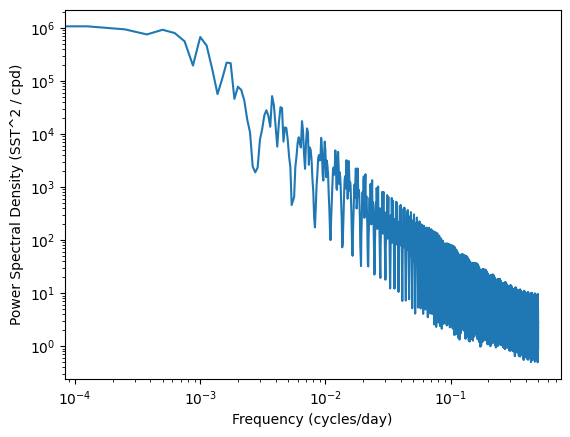

In [198]:
f, Pw = welch(frozen, fs=1.0, window="hamming", nperseg= 8000) #fs = sampling frequency

fig, ax = plt.subplots()
ax.plot(f, Pw)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Power Spectral Density (SST^2 / cpd)")
plt.show()

Since we are looking at the rate of change in the annual number of days frozen and have already created a new grouped sum dataset this graph was not used to find a specific trend in the time series but can still be helpful when looking at the trend of our data.

## Trailing Window

The code below uses the new dataset to forecast the data into the future

In [199]:
year = days_frozen_df["year"].values.reshape(-1, 1)
days_frozen = days_frozen_df["days_frozen"].values.reshape(-1, 1)

w = 30 #30 year window
k = 25 #predicts 25 years into the future

In [200]:
year_lag = np.zeros((len(year) - w, w))
for ii in range(w):
    year_lag[:, ii] = year[ii:ii + len(year) - w, :].squeeze()

frozen_days_lagged = days_frozen[w:]

In [201]:
temp_year = year[-1][0]
future_year = np.arange(temp_year + 1, temp_year + k + 1).reshape(-1, 1)
all_years = np.vstack([year, future_year]) #combines the year sets

future_year_lag = np.hstack([all_years[-(k + w) + i: -w + i] for i in range(w)])

#future_year_lag = np.zeros((k, w))
#for ii in range(w):
#    future_year_lag[:, ii] = all_years[-(k + w) + ii:-w + ii, :].squeeze()

In [202]:
reg = LinearRegression().fit(year_lag, frozen_days_lagged)
frozen_pred = reg.predict(year_lag)
future_frozen_pred = reg.predict(future_year_lag) #forcasted frozen days
mae = np.nanmean(np.abs(frozen_pred - frozen_days_lagged)) #avg difference in predicted frozen days from frozen days of the past 30 years (w)

years = pd.date_range(start=str(year[0][0]), periods=len(year), freq='A') # 1940-2023 w yearly frequency

future_years = pd.date_range(start=str(future_year[0][0]), periods=k, freq='A') #2023-2048 w yearly frequency

The code below plots the graph using the values calculated above

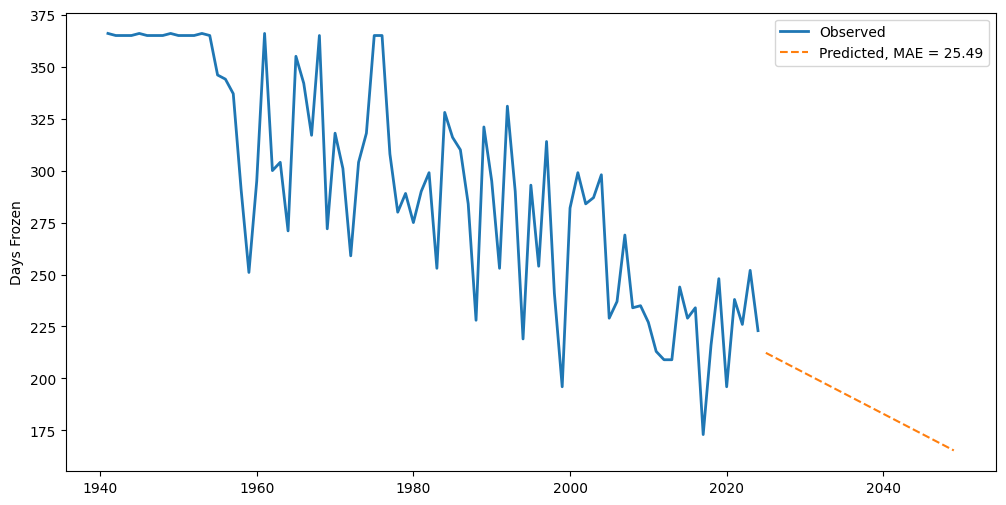

In [203]:
fig, ax = plt.subplots()
ax.plot(years, days_frozen, '-', linewidth=2, label="Observed")
ax.plot(future_years, future_frozen_pred, '--', label=f"Predicted, MAE = {mae:.2f}")
ax.legend()
ax.set_xlabel("") #years are self-explanatory
ax.set_ylabel("Days Frozen")
fig.set_size_inches(10, 5)
fig.tight_layout(pad=0.5)
plt.show()


As shown by the graph the forecasted trend displays an overall decline in the annual number of days the Arctic will remain frozen. With a MAE of 25.49 (compared to the 365 days in a year) we can see that the model can be a good indicator but is certainly not a perfect prediction of our data.

## Additional Step

The additional step is to look at the (average) sea surface temperature across the dataset.This answers the question "does the average sea surface temperature relate to the annual number of days the artic ocean remains frozen".

In [204]:
sst = df["sst"].values #artic sea surface temp

In [205]:
df

sst        u10  hsig                 time  latitude  longitude  \
0      271.45996   0.009604   NaN  1940-01-01 12:00:00        70     -140.1   
1      271.45996   6.529120   NaN  1940-01-02 12:00:00        70     -140.1   
2      271.45996   5.675279   NaN  1940-01-03 12:00:00        70     -140.1   
3      271.45996 -10.479511   NaN  1940-01-04 12:00:00        70     -140.1   
4      271.45996 -14.644253   NaN  1940-01-05 12:00:00        70     -140.1   
...          ...        ...   ...                  ...       ...        ...   
30742  271.45996   7.196524   NaN  2024-03-02 12:00:00        70     -140.1   
30743  271.46017   5.576620   NaN  2024-03-03 12:00:00        70     -140.1   
30744  271.46017  -4.742743   NaN  2024-03-04 12:00:00        70     -140.1   
30745  271.45996  -6.829830   NaN  2024-03-05 12:00:00        70     -140.1   
30746  271.45996  -5.576272   NaN  2024-03-06 12:00:00        70     -140.1   

       year  days_frozen  
0      1940          366  
1      1940          366  
2      1940          366  
3      1940          366  
4      1940          366  
...     ...          ...  
30742  2024           66  
30743  2024           66  
30744  2024           66  
30745  2024           66  
30746  2024           66  

[30747 rows x 8 columns]

In [206]:
import altair as alt

alt.data_transformers.enable('default', max_rows=None)

alt.Chart(df).mark_line(point = True).encode(
    alt.X('year(time)', title = ""),
    alt.Y('mean(sst)', title = "Sea Surface Temp (Kelvin)", scale = alt.Scale(domain=[270, 275])) #note that this chart does not start from 0
).properties(width=850, height=250)

alt.Chart(...)

From this chart we can see that while there is some variation the overall trend shows increasingly higher yearly temperatures. So to answer the above question it does seem like there is a relationship between average temperature and the number of days frozen but we can't be sure that one is necessarily causing the other.